In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# collect the dataset which is already preprocessed and feature engineered
df_train = pd.read_csv(r"C:\Users\dhanu\OneDrive\Desktop\cdc project\train_preprocessed.csv")
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,basements_ratio,above_floors_ratio,living_density,lot_density,year_sale,month_sale,quarter_sale,days_since_start,renovation,years_since_renovation
0,1000102,2014-09-16,280000,6,3.00,2400,9373,2.0,0,0,...,0.0,0.999584,1.164483,16690,2014,9,3,137,0,0
1,1001200050,2014-09-23,259000,4,1.50,1260,7248,1.5,0,0,...,0.0,0.999207,0.968486,14981,2014,9,3,144,0,0
2,1003000175,2014-12-22,221000,3,1.00,980,7606,1.0,0,0,...,0.0,0.998981,0.998981,15732,2014,12,4,234,0,0
3,100300280,2014-10-20,355000,3,2.25,1430,4777,2.0,0,0,...,0.0,0.999301,0.871951,8632,2014,10,4,171,0,0
4,100300530,2014-09-25,330000,3,2.50,1520,3003,2.0,0,0,...,0.0,0.999343,0.834706,6034,2014,9,3,146,0,0


In [3]:
# separate the data accordingly

x = df_train.drop(columns = ["id", "date", "price"])

# need to keep the prices symmetric instead of skewed -> apply log transform on prices
y_log = np.log1p(df_train["price"])

x_train, x_val, y_train, y_val = train_test_split(x, y_log, test_size = 0.2, random_state = 42)

print(f"x_train shape : {x_train.shape}\nx_val shape : {x_val.shape}\ny_train shape : {y_train.shape}\ny_val shape : {y_val.shape}")

x_train shape : (12888, 31)
x_val shape : (3222, 31)
y_train shape : (12888,)
y_val shape : (3222,)


In [4]:
# initialize the model and parameter search
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [5]:
params = {
    "n_estimators" : randint(300,800),
    "max_depth" : randint(3,10),
    "learning_rate": uniform(0.01, 0.1),
    "subsample" : uniform(0.6, 0.4),
    "min_child_weight" : randint(1,10),
    "gamma" : uniform(0,0.3)
}

In [6]:
xgb_model = XGBRegressor(
    objective = "reg:squarederror",
    n_jobs = -1,
    random_state = 42
)

random_search =  RandomizedSearchCV(
    estimator = xgb_model,
    param_distributions = params,
    n_iter = 40, 
    scoring = "r2",
    cv = 3,
    verbose = 1,
    random_state = 42,
    n_jobs = -1
)

In [7]:
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'gamma': <scipy.stats....0026E79EEEB90>, 'learning_rate': <scipy.stats....0026E79EEEE60>, 'max_depth': <scipy.stats....0026E79EEE650>, 'min_child_weight': <scipy.stats....0026E79EEEFB0>, ...}"
,n_iter,40
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [8]:
best_xgb = random_search.best_estimator_

print(f"Best Parameters : {random_search.best_params_}")

Best Parameters : {'gamma': np.float64(0.012130076861529403), 'learning_rate': np.float64(0.08106628896857873), 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 362, 'subsample': np.float64(0.9583054382694077)}


In [9]:
y_pred_log = best_xgb.predict(x_val)

y_pred_actual = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_actual))
r2 = r2_score(y_true, y_pred_actual)

print("RMSE :", rmse)
print("R squared score :", r2)

RMSE : 113429.77398510119
R squared score : 0.8909305044472117


In [10]:
print("Percent of Error observed in Predictions :", (rmse/np.mean(df_train["price"]))*100, "%")

Percent of Error observed in Predictions : 21.063287732201236 %


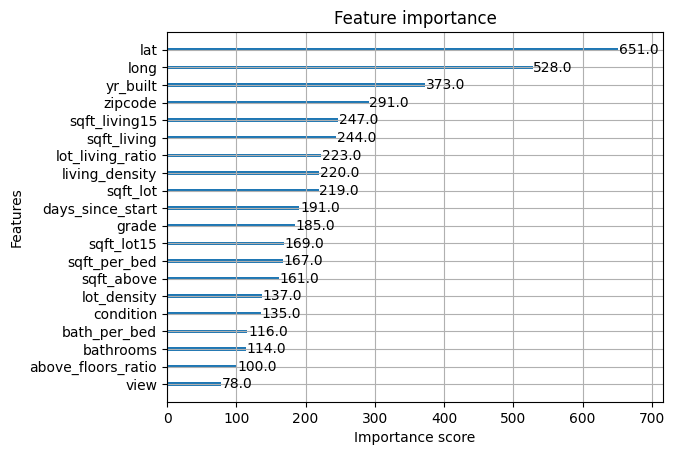

In [11]:
# Let's have a look at the feature importance based on what the model learnt from the training data

import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_xgb, max_num_features = 20)
plt.show()

In [15]:
# let's save the model so that we can re-use in the future if needed

from joblib import dump
dump(best_xgb, r"C:\Users\dhanu\OneDrive\Desktop\cdc project\model\XGB_Tab.joblib")

['C:\\Users\\dhanu\\OneDrive\\Desktop\\cdc project\\model\\XGB_Tab.joblib']

In [17]:
# now that the model is saved, let's test the model on the testing dataset and save our predictions

df_test = pd.read_csv(r"C:\Users\dhanu\OneDrive\Desktop\cdc project\test_preprocessed.csv")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      5404 non-null   int64  
 1   date                    5404 non-null   object 
 2   bedrooms                5404 non-null   int64  
 3   bathrooms               5404 non-null   float64
 4   sqft_living             5404 non-null   int64  
 5   sqft_lot                5404 non-null   int64  
 6   floors                  5404 non-null   float64
 7   waterfront              5404 non-null   int64  
 8   view                    5404 non-null   int64  
 9   condition               5404 non-null   int64  
 10  grade                   5404 non-null   int64  
 11  sqft_above              5404 non-null   int64  
 12  sqft_basement           5404 non-null   int64  
 13  yr_built                5404 non-null   int64  
 14  yr_renovated            5404 non-null   

In [40]:
# need to change the id dtype again back to str
df_test["id"] = df_test["id"].astype(str)

In [22]:
x_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqft_per_bed', 'bath_per_bed',
       'lot_living_ratio', 'basements_ratio', 'above_floors_ratio',
       'living_density', 'lot_density', 'year_sale', 'month_sale',
       'quarter_sale', 'days_since_start', 'renovation',
       'years_since_renovation'],
      dtype='object')

In [ ]:
FEATURE_COLUMNS = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqft_per_bed', 'bath_per_bed',
       'lot_living_ratio', 'basements_ratio', 'above_floors_ratio',
       'living_density', 'lot_density', 'year_sale', 'month_sale',
       'quarter_sale', 'days_since_start', 'renovation',
       'years_since_renovation']
x_test_tab = df_test[FEATURE_COLUMNS]

# getting predictions from the testing data
y_pred_test_log = best_xgb.predict(x_test_tab)
y_pred_test_log[:5]

array([12.828093, 13.650603, 13.912721, 14.559131, 13.455407],
      dtype=float32)

In [29]:
# the values are small because the model is trained on log(price) values, need to undo the log

y_pred_test = np.expm1(y_pred_test_log)
y_pred_test[:5]

array([ 372536.34,  847971.3 , 1102090.9 , 2103535.8 ,  697603.2 ],
      dtype=float32)

In [35]:
# now let's save these values with their respective ids

tabular_xgb_predictions = pd.DataFrame({
    "id" : df_test["id"],
    "predicted_price" : y_pred_test
})


In [38]:
# checking to make sure that there are no mistakes in the predictions

assert len(tabular_xgb_predictions) == len(df_test)
assert tabular_xgb_predictions["predicted_price"].min() > 0

In [36]:
tabular_xgb_predictions.head()

,id,predicted_price
0,2591820310,3.725363e+05
1,7974200820,8.479713e+05
2,7701450110,1.102091e+06
3,9522300010,2.103536e+06
4,9510861140,6.976032e+05


In [39]:
# saving the predictions in a csv file

tabular_xgb_predictions.to_csv(r"C:\Users\dhanu\OneDrive\Desktop\cdc project\predictions\xgb_tabular_predictions.csv",  index = False)